# SET: 23-11-06 RAW


In [35]:
# Importing standard data analysis and visualization libraries
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For advanced data visualization
import matplotlib.pyplot as plt  # For basic plotting and visualization
from scipy.stats import ttest_ind, mannwhitneyu  # For statistical tests
from sklearn.cluster import KMeans

# Importing custom utility functions for specific data processing tasks
from Utils_ipynb import (
    append_csv_files_from_subfolders,  # Function to concatenate CSV files from subfolders
    extract_and_append_image_info,  # Function to extract and append image information from data
    filter_dataframe,  # Function to filter data based on specific criteria
    get_correlation_matrices_plt,  # Function to create and plot correlation matrices
    refine_and_filter_data , # Function to refine and further filter data
    plot_metrics_by_group_and_ring
)

# Settings

In [36]:
RING_COEFF_CUT_OFF = 1.2

## Data Preparation

### Step 1: Data Read
- **Objective**: Combine 'cell_stat.csv' files from various subdirectories within a specified root folder into a single DataFrame.
- **Context**: This step aggregates data collected from parallel analyses conducted on the Borah cluster.
- **Data Format**: Each 'cell_stat.csv' file contains [brief description of data, like columns and typical values].
- **Note**: [Any specific filters or considerations applied during aggregation, if applicable].



In [37]:
# Read files from each subdirctory
root_folder = r'C:\Users\nnina\Documents\BioLab_C\Current_experiments_C\Anamaria_3d_experiment_C\23-11-06-RAW\analysis_data'
combined_df = append_csv_files_from_subfolders(root_folder)
combined_df

,Image_name,Img_num,Cell_num,"Nucleus_volume, cubic_micrometre","Nucleus_cylinder, pixels_number","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",Cy5-T1 av_signal_in_nuc_area_3D,Cy5-T1 sum_pix_in_nuc_cylinder,Cy5-T1 has ring,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 sum_pix_in_nuc_cylinder,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 sum_pix_in_nuc_cylinder,AF488-T3 has ring,AF488-T3 ring intensity coef
0,23-11-06 KASH+doxy -LIV -Cisplatin 0hr-25.czi,0,0,588.016552,1085688,23.048709,24.409518,2.53,3518.799858,2593997771,False,0.902363,2683.759129,2337097281,True,1.179702,2465.656269,1929865609,False,0.987409
1,23-11-06 KASH+doxy -LIV -Cisplatin 0hr-25.czi,0,1,540.638555,1127712,24.749720,24.239417,2.30,2841.804682,2213269926,False,0.930728,3667.358306,3231973084,True,1.177271,2198.614977,1747323116,False,0.869759
2,23-11-06 KASH+doxy -LIV -Cisplatin 0hr-11.czi,1,0,2768.567324,3627416,32.149121,40.313978,4.83,6791.913500,17267554290,False,0.928434,5685.987431,18486884703,True,2.008731,2004.078152,5469874032,False,0.939037
3,23-11-06 KASH+doxy -LIV -Cisplatin 0hr-27.czi,2,0,891.602080,1702210,34.870740,23.814164,2.99,3651.654741,4018221331,False,0.766046,2911.321222,3957048667,True,1.139822,1865.570337,2258411366,True,1.015875
4,23-11-06 KASH+doxy -LIV -Cisplatin 0hr-27.czi,2,1,1117.738553,2136626,27.726491,37.252157,2.99,3634.273310,4832199299,False,0.933999,2644.799671,4140802959,True,1.130765,2012.298837,2876566812,True,1.038466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,23-11-06 MSC -LIV 10uM 6x vib 48hr-33.czi,34,2,1088.252292,1197265,19.221432,24.664670,4.60,17747.533682,16569504111,False,0.973064,345.779456,378887494,False,0.973917,2766.788155,2706762006,False,0.977291
1757,23-11-06 MSC -LIV 10uM 6x vib 48hr-19.czi,35,0,1557.044397,1878828,24.579619,25.430125,5.52,13549.113627,18191986516,True,1.007055,291.565752,491562513,True,1.031406,2180.167621,3088038534,True,1.015886
1758,23-11-06 MSC -LIV 10uM 6x vib 48hr-19.czi,35,1,1068.720952,1620472,24.239417,22.198203,4.60,10875.476700,10050821104,True,1.184104,331.755870,414781368,True,1.155722,1992.274797,1965515821,True,1.089903
1759,23-11-06 MSC -LIV 10uM 6x vib 48hr-19.czi,35,2,1665.665071,1826216,23.218810,25.430125,5.52,16639.930835,20985995755,True,1.038928,371.680549,572950977,False,0.940469,2708.646364,3538828996,False,0.998788


#### Step 2: Extraction of Experimental Setup and Group Information from Image Names
Extraction detailed information about the experimental setup and group, as well as the processing type, directly from the 'Image_name' column in our DataFrame. This is achieved through the extract_and_append_image_info function. The 'Image_name' column is a rich source of data, encapsulating key aspects of the experiment and image processing in a condensed format:
- Processing: Indicates the type of image processing used, such as 'RAW' or 'LSM'.
- Date: The date when the image was captured.
- Time: Time point of the experiment, typically 0, 24, or 48 hours.
- Cell Type: Identifies the cell type, e.g., 'KASH', 'KASH+doxy', or 'MSC'.
- LIV: Indicates the presence (+LIV) or absence (-LIV) of LIV in the sample.
- Cisp: Shows the concentration of Cisplatin used, or 'Control' if not applicable.

In [38]:
enhanced_df = extract_and_append_image_info(combined_df, 'Image_name')

#### Step 3: Removing Inaccurate Nuclei Detections
Although the 3D Signal Detector generally performs well in identifying signals within the nucleus area, manual verification of each image is still necessary. This step ensures the accurate processing of nuclei, particularly for retaining edge cells. While edge cells are often removed, some that are barely touching the image's edge may be viable for analysis and are, therefore, preserved.

Another challenge involves distinguishing between dividing nuclei and those with irregular shapes. While automation is possible for this task, we have chosen to assess the processed data manually. This assessment involves examining each image's maximum projection, focusing on specific cut-out areas and the mesh of nuclei.

Any cells identified for removal are listed in a CSV file with columns "Image_name" and "Cell_num". This file serves as a record of cells excluded from the analysis.

In [39]:
remove_nuclei_path = r"C:\Users\nnina\Documents\BioLab_C\Current_experiments_C\Anamaria_3d_experiment_C\23-11-06-RAW\cells_to_remove.xlsx"
remove_df = pd.read_excel(remove_nuclei_path)
enhanced_remove_df = extract_and_append_image_info(remove_df, 'Image_name')

with pd.ExcelWriter(r'output_data_files/23-11-06-removed_cells_data.xlsx') as writer:
    enhanced_remove_df.to_excel(writer, index=False)

enhanced_remove_df

,Image_name,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Cell_num
0,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-12,LSM,23-11-06,0,KASH,-LIV,10um,0
1,23-11-06 KASH +doxy +LIV 10uM 6x vib 24hr-15,23-11-06KASH+doxy+LIV10uM6xvib24hr-15,RAW,23-11-06,24,KASH+doxy,+LIV,10um,0
2,23-11-06 KASH +doxy +LIV 10uM 6x vib 24hr-18,23-11-06KASH+doxy+LIV10uM6xvib24hr-18,RAW,23-11-06,24,KASH+doxy,+LIV,10um,2
3,23-11-06 KASH +doxy +LIV 10uM 6x vib 24hr-22,23-11-06KASH+doxy+LIV10uM6xvib24hr-22,RAW,23-11-06,24,KASH+doxy,+LIV,10um,0
4,23-11-06 KASH +doxy +LIV 10uM 6x vib 24hr-23,23-11-06KASH+doxy+LIV10uM6xvib24hr-23,RAW,23-11-06,24,KASH+doxy,+LIV,10um,0
...,...,...,...,...,...,...,...,...,...
156,23-11-06 MSC -LIV 10uM 6x vib 48hr-25,23-11-06MSC-LIV10uM6xvib48hr-25,RAW,23-11-06,48,MSC,-LIV,10um,0
157,23-11-06 MSC -LIV 10uM 6x vib 48hr-30,23-11-06MSC-LIV10uM6xvib48hr-30,RAW,23-11-06,48,MSC,-LIV,10um,0
158,23-11-06 MSC -LIV 10uM 6x vib 48hr-31,23-11-06MSC-LIV10uM6xvib48hr-31,RAW,23-11-06,48,MSC,-LIV,10um,0
159,23-11-06 MSC -LIV 10uM 6x vib 48hr-31,23-11-06MSC-LIV10uM6xvib48hr-31,RAW,23-11-06,48,MSC,-LIV,10um,1


In [40]:
columns_to_compare = ['Base_image_name', 'Processing', 'Date', 'Time', 'Cell Type', 'LIV', 'Cisp', 'Cell_num']

# Perform a left anti join
enhanced_df = enhanced_df.merge(enhanced_remove_df[columns_to_compare], on=columns_to_compare, how='left', indicator=True)
enhanced_df = enhanced_df[enhanced_df['_merge'] == 'left_only'].drop('_merge', axis=1)
enhanced_df

,Image_name,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Img_num,Cell_num,...,Cy5-T1 has ring,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 sum_pix_in_nuc_cylinder,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 sum_pix_in_nuc_cylinder,AF488-T3 has ring,AF488-T3 ring intensity coef
0,23-11-06 KASH+doxy -LIV -Cisplatin 0hr-25.czi,23-11-06KASH+doxy-LIV-Cisplatin0hr-25.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,0,0,...,False,0.902363,2683.759129,2337097281,True,1.179702,2465.656269,1929865609,False,0.987409
1,23-11-06 KASH+doxy -LIV -Cisplatin 0hr-25.czi,23-11-06KASH+doxy-LIV-Cisplatin0hr-25.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,0,1,...,False,0.930728,3667.358306,3231973084,True,1.177271,2198.614977,1747323116,False,0.869759
2,23-11-06 KASH+doxy -LIV -Cisplatin 0hr-11.czi,23-11-06KASH+doxy-LIV-Cisplatin0hr-11.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,1,0,...,False,0.928434,5685.987431,18486884703,True,2.008731,2004.078152,5469874032,False,0.939037
3,23-11-06 KASH+doxy -LIV -Cisplatin 0hr-27.czi,23-11-06KASH+doxy-LIV-Cisplatin0hr-27.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,2,0,...,False,0.766046,2911.321222,3957048667,True,1.139822,1865.570337,2258411366,True,1.015875
4,23-11-06 KASH+doxy -LIV -Cisplatin 0hr-27.czi,23-11-06KASH+doxy-LIV-Cisplatin0hr-27.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,2,1,...,False,0.933999,2644.799671,4140802959,True,1.130765,2012.298837,2876566812,True,1.038466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,23-11-06 MSC -LIV 10uM 6x vib 48hr-33.czi,23-11-06MSC-LIV10uM6xvib48hr-33.czi,RAW,23-11-06,48,MSC,-LIV,10um,34,2,...,False,0.973064,345.779456,378887494,False,0.973917,2766.788155,2706762006,False,0.977291
1757,23-11-06 MSC -LIV 10uM 6x vib 48hr-19.czi,23-11-06MSC-LIV10uM6xvib48hr-19.czi,RAW,23-11-06,48,MSC,-LIV,10um,35,0,...,True,1.007055,291.565752,491562513,True,1.031406,2180.167621,3088038534,True,1.015886
1758,23-11-06 MSC -LIV 10uM 6x vib 48hr-19.czi,23-11-06MSC-LIV10uM6xvib48hr-19.czi,RAW,23-11-06,48,MSC,-LIV,10um,35,1,...,True,1.184104,331.755870,414781368,True,1.155722,1992.274797,1965515821,True,1.089903
1759,23-11-06 MSC -LIV 10uM 6x vib 48hr-19.czi,23-11-06MSC-LIV10uM6xvib48hr-19.czi,RAW,23-11-06,48,MSC,-LIV,10um,35,2,...,True,1.038928,371.680549,572950977,False,0.940469,2708.646364,3538828996,False,0.998788


## Step 4: Data Filtering and Refinement
In this section, we aim to streamline our dataset for more efficient analysis. The objectives are:
1. Remove any columns that are not relevant to our analysis to simplify the dataset.
2. Create new columns that will aid in deeper insights and facilitate a more thorough examination of the data.
3. Rename existing columns for clarity and better understanding. This involves modifying column names so that they accurately describe the data they represent, making the dataset more intuitive for anyone reviewing this analysis.


In [41]:
# Define the pixel size in microns
pixel_size = 0.085 * 0.085 * 0.230  # in cubic microns

refined_df = refine_and_filter_data(enhanced_df, pixel_size)

In [42]:
refined_df

,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Img_num,Cell_num,Nucleus_volume,Nucleus_height,Average_signal_594,Ring_coefficient,Average_signal_488,Total_signal_488,Group
0,23-11-06KASH+doxy-LIV-Cisplatin0hr-25.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,0,0,588.016552,2.53,2683.759129,1.179702,2465.656269,8.724818e+08,KASH+doxy_-LIV_-cisplatin_0hr
1,23-11-06KASH+doxy-LIV-Cisplatin0hr-25.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,0,1,540.638555,2.30,3667.358306,1.177271,2198.614977,7.153038e+08,KASH+doxy_-LIV_-cisplatin_0hr
2,23-11-06KASH+doxy-LIV-Cisplatin0hr-11.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,1,0,2768.567324,4.83,5685.987431,2.008731,2004.078152,3.338905e+09,KASH+doxy_-LIV_-cisplatin_0hr
3,23-11-06KASH+doxy-LIV-Cisplatin0hr-27.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,2,0,891.602080,2.99,2911.321222,1.139822,1865.570337,1.000961e+09,KASH+doxy_-LIV_-cisplatin_0hr
4,23-11-06KASH+doxy-LIV-Cisplatin0hr-27.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,2,1,1117.738553,2.99,2644.799671,1.130765,2012.298837,1.353527e+09,KASH+doxy_-LIV_-cisplatin_0hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,23-11-06MSC-LIV10uM6xvib48hr-33.czi,RAW,23-11-06,48,MSC,-LIV,10um,34,2,1088.252292,4.60,345.779456,0.973917,2766.788155,1.811923e+09,MSC_-LIV_10um_48hr
1757,23-11-06MSC-LIV10uM6xvib48hr-19.czi,RAW,23-11-06,48,MSC,-LIV,10um,35,0,1557.044397,5.52,291.565752,1.031406,2180.167621,2.042797e+09,MSC_-LIV_10um_48hr
1758,23-11-06MSC-LIV10uM6xvib48hr-19.czi,RAW,23-11-06,48,MSC,-LIV,10um,35,1,1068.720952,4.60,331.755870,1.155722,1992.274797,1.281291e+09,MSC_-LIV_10um_48hr
1759,23-11-06MSC-LIV10uM6xvib48hr-19.czi,RAW,23-11-06,48,MSC,-LIV,10um,35,2,1665.665071,5.52,371.680549,0.940469,2708.646364,2.715028e+09,MSC_-LIV_10um_48hr


In [43]:
refined_df.loc[:, "Ring"] = refined_df["Ring_coefficient"] >= RING_COEFF_CUT_OFF

# Initial Data Investigation

In [44]:
# Filter out rows where 'Processing' is 'RAW'
raw_df = refined_df[refined_df['Processing'] == 'RAW']

# Group the filtered DataFrame based on the 'Group' column
grouped_raw_df = raw_df.groupby('Group')

# Aggregate the specified columns with count, mean, median, and std
aggregated_raw_df = grouped_raw_df.agg({
    'Nucleus_volume': ['count', 'mean', 'median', 'std'],
    'Nucleus_height': ['mean', 'median', 'std'],
    'Average_signal_488': ['mean', 'median', 'std'],
    'Total_signal_488': ['mean', 'median', 'std']
})

aggregated_raw_df

#Save lsm_df data
with pd.ExcelWriter(r'output_data_files/23-11-06-aggregated-raw-data.xlsx') as writer:
    raw_df.to_excel(writer, index=False)

In [45]:
# Filter the DataFrame based on conditions
condition_kash_doxy = (raw_df['Cell Type'] == 'KASH+doxy') & (raw_df['Ring_coefficient'] > RING_COEFF_CUT_OFF)
condition_kash_msc = (raw_df['Cell Type'].isin(['KASH', 'MSC'])) & (raw_df['Ring_coefficient'] <= RING_COEFF_CUT_OFF)

final_df = raw_df[condition_kash_doxy | condition_kash_msc]

final_df

,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Img_num,Cell_num,Nucleus_volume,Nucleus_height,Average_signal_594,Ring_coefficient,Average_signal_488,Total_signal_488,Group,Ring
2,23-11-06KASH+doxy-LIV-Cisplatin0hr-11.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,1,0,2768.567324,4.83,5685.987431,2.008731,2004.078152,3.338905e+09,KASH+doxy_-LIV_-cisplatin_0hr,True
5,23-11-06KASH+doxy-LIV-Cisplatin0hr-27.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,2,2,917.577042,2.76,3032.684152,1.233978,1631.009958,9.006032e+08,KASH+doxy_-LIV_-cisplatin_0hr,True
11,23-11-06KASH+doxy-LIV-Cisplatin0hr-06.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,5,1,395.076454,1.84,2525.494474,1.204601,2501.697277,5.947716e+08,KASH+doxy_-LIV_-cisplatin_0hr,True
12,23-11-06KASH+doxy-LIV-Cisplatin0hr-32.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,6,0,407.037830,3.22,1830.990997,1.402232,3280.580244,8.035627e+08,KASH+doxy_-LIV_-cisplatin_0hr,True
13,23-11-06KASH+doxy-LIV-Cisplatin0hr-32.czi,RAW,23-11-06,0,KASH+doxy,-LIV,-cisplatin,6,1,382.185886,3.45,2067.158756,1.511466,3106.693140,7.145084e+08,KASH+doxy_-LIV_-cisplatin_0hr,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,23-11-06MSC-LIV10uM6xvib48hr-33.czi,RAW,23-11-06,48,MSC,-LIV,10um,34,2,1088.252292,4.60,345.779456,0.973917,2766.788155,1.811923e+09,MSC_-LIV_10um_48hr,False
1757,23-11-06MSC-LIV10uM6xvib48hr-19.czi,RAW,23-11-06,48,MSC,-LIV,10um,35,0,1557.044397,5.52,291.565752,1.031406,2180.167621,2.042797e+09,MSC_-LIV_10um_48hr,False
1758,23-11-06MSC-LIV10uM6xvib48hr-19.czi,RAW,23-11-06,48,MSC,-LIV,10um,35,1,1068.720952,4.60,331.755870,1.155722,1992.274797,1.281291e+09,MSC_-LIV_10um_48hr,False
1759,23-11-06MSC-LIV10uM6xvib48hr-19.czi,RAW,23-11-06,48,MSC,-LIV,10um,35,2,1665.665071,5.52,371.680549,0.940469,2708.646364,2.715028e+09,MSC_-LIV_10um_48hr,False


In [46]:
# Group the filtered DataFrame based on the 'Group' column
grouped_ring_filtered_raw_df = final_df.groupby('Group')

# Aggregate the specified columns with count, mean, median, and std
aggregated_ring_filtered_raw_df = grouped_ring_filtered_raw_df.agg({
    'Nucleus_volume': ['count', 'mean', 'median', 'std'],
    'Nucleus_height': ['mean', 'median', 'std'],
    'Average_signal_488': ['mean', 'median', 'std'],
    'Total_signal_488': ['mean', 'median', 'std']
})

aggregated_ring_filtered_raw_df

Nucleus_volume                            \
                                       count         mean       median   
Group                                                                    
KASH+doxy_+LIV_10um_0hr                   22  1242.846662  1378.530489   
KASH+doxy_+LIV_10um_24hr                  38  1760.460839  1574.132136   
KASH+doxy_+LIV_10um_48hr                  42  2404.438993  2097.295303   
KASH+doxy_-LIV_-cisplatin_0hr             32   802.015136   484.388311   
KASH+doxy_-LIV_10um_0hr                   22   991.536390   668.971916   
KASH+doxy_-LIV_10um_24hr                  15   589.059377   432.881357   
KASH+doxy_-LIV_10um_48hr                  80  1286.626678  1160.346639   
KASH_+LIV_10um_0hr                        97   960.974216   861.550153   
KASH_+LIV_10um_24hr                      101  1542.078722  1487.102083   
KASH_-LIV_-cisplatin_0hr                 101   748.209868   653.530020   
KASH_-LIV_10um_0hr                        91   850.525694   778.764687   
KASH_-LIV_10um_24hr                       93  1092.022221   982.885040   
KASH_-LIV_10um_48hr                       62  1295.514825   977.080291   
MSC_+LIV_10um_0hr                         98  1019.394059   956.115648   
MSC_+LIV_10um_24hr                        99  1509.206732  1422.663383   
MSC_+LIV_10um_48hr                        86  1203.804079  1082.516173   
MSC_-LIV_-cisplatin_0hr                   80   813.520588   645.427247   
MSC_-LIV_10um_0hr                         97   809.739546   706.972307   
MSC_-LIV_10um_24hr                       103  1586.044194  1533.956836   
MSC_-LIV_10um_48hr                       117  1804.455861  1598.770707   

                                           Nucleus_height                   \
                                       std           mean median       std   
Group                                                                        
KASH+doxy_+LIV_10um_0hr         497.120599       4.108636  3.910  0.628060   
KASH+doxy_+LIV_10um_24hr       1079.817251       4.569737  4.485  0.581296   
KASH+doxy_+LIV_10um_48hr       1633.896635       4.934048  4.945  0.725908   
KASH+doxy_-LIV_-cisplatin_0hr   658.500140       3.169687  2.990  0.693046   
KASH+doxy_-LIV_10um_0hr         856.661956       4.495455  3.565  2.548084   
KASH+doxy_-LIV_10um_24hr        330.393289       2.499333  2.300  0.527832   
KASH+doxy_-LIV_10um_48hr        712.977069       4.079625  4.025  0.711259   
KASH_+LIV_10um_0hr              448.418964       3.433402  3.450  0.529341   
KASH_+LIV_10um_24hr             561.918762       4.162772  4.140  0.423481   
KASH_-LIV_-cisplatin_0hr        358.820326       2.919406  2.990  0.369066   
KASH_-LIV_10um_0hr              364.133595       3.161868  2.990  0.568155   
KASH_-LIV_10um_24hr             468.406080       3.262043  3.220  0.714520   
KASH_-LIV_10um_48hr            1191.707196       3.405484  3.450  0.696678   
MSC_+LIV_10um_0hr               460.364128       3.837245  3.680  0.603209   
MSC_+LIV_10um_24hr              713.794403       4.465253  4.370  0.468154   
MSC_+LIV_10um_48hr              658.495622       3.982209  3.910  0.681616   
MSC_-LIV_-cisplatin_0hr         471.447306       3.711625  3.680  0.517209   
MSC_-LIV_10um_0hr               377.217088       3.777216  3.680  0.574842   
MSC_-LIV_10um_24hr              659.622156       4.521845  4.370  0.680580   
MSC_-LIV_10um_48hr             1059.415470       4.814274  4.830  0.809083   

                              Average_signal_488                            \
                                            mean       median          std   
Group                                                                        
KASH+doxy_+LIV_10um_0hr              4297.755537  4152.023756  1286.562941   
KASH+doxy_+LIV_10um_24hr             3727.567412  3334.381386  1474.426068   
KASH+doxy_+LIV_10um_48hr             2302.624805  2216.990569   602.033272   
KASH+doxy_-LIV_-cisplatin_0hr        3894.992219  3337.742869  1

### Cell-Type Specific Scatter Plot Analysis

***Overview**
This section is dedicated to exploring the potential correlation between nuclear volume and signal intensity within different cell types. Specifically, we visualize two relationships for each unique cell type in our dataset:

'Nucleus Volume' vs 'Average Signal 488'
'Nucleus Volume' vs 'Total Signal 488'
For each cell type, separate scatter plots are generated, enabling a detailed and comparative analysis across varying cellular conditions.

**Objective**
The primary aim of these visualizations is to investigate whether there is a discernible correlation between the nucleus volume and signal intensity (both average and total). Understanding this relationship is crucial for assessing the impact of experimental variables, such as vibrations, on cellular repair mechanisms.

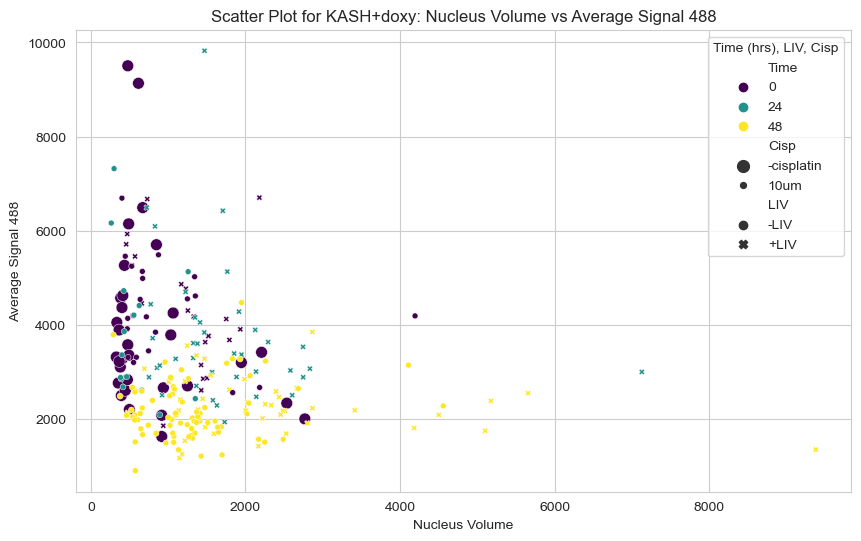

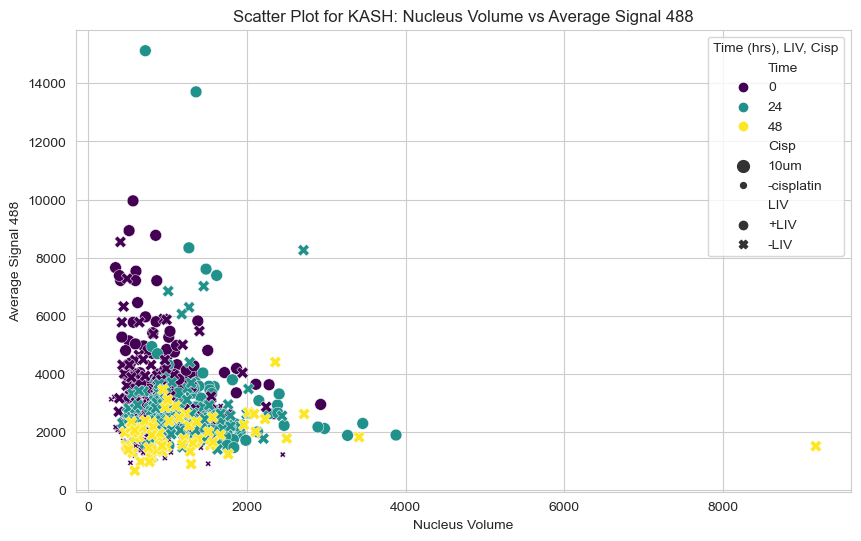

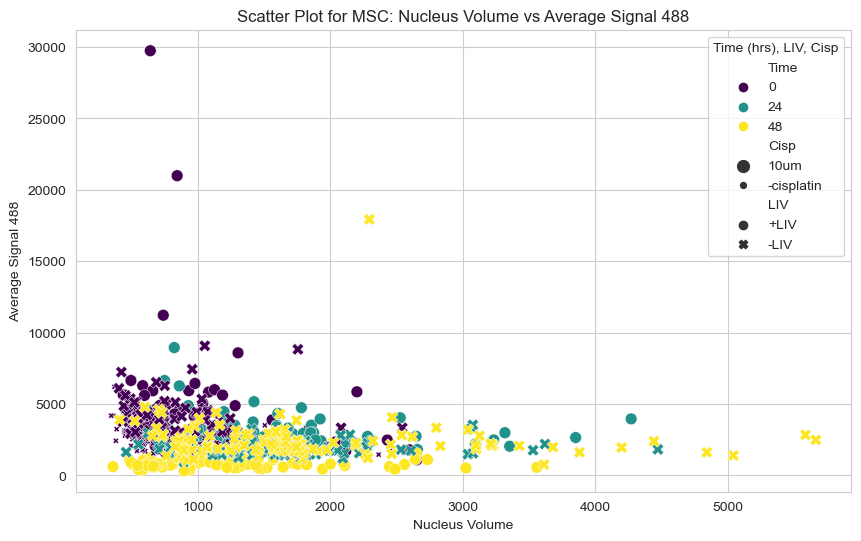

In [47]:
cell_types = final_df['Cell Type'].unique()

# Create a scatter plot for each cell type
for cell_type in cell_types:
    # Filter the DataFrame for the current cell type
    df_cell = final_df[final_df['Cell Type'] == cell_type]

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_cell, x='Nucleus_volume', y='Average_signal_488',
                    hue='Time', style='LIV', size='Cisp', palette='viridis')

    # Adding plot title and labels
    plt.title(f'Scatter Plot for {cell_type}: Nucleus Volume vs Average Signal 488')
    plt.xlabel('Nucleus Volume')
    plt.ylabel('Average Signal 488')

    # Show the plot
    plt.legend(title='Time (hrs), LIV, Cisp')
    plt.show()

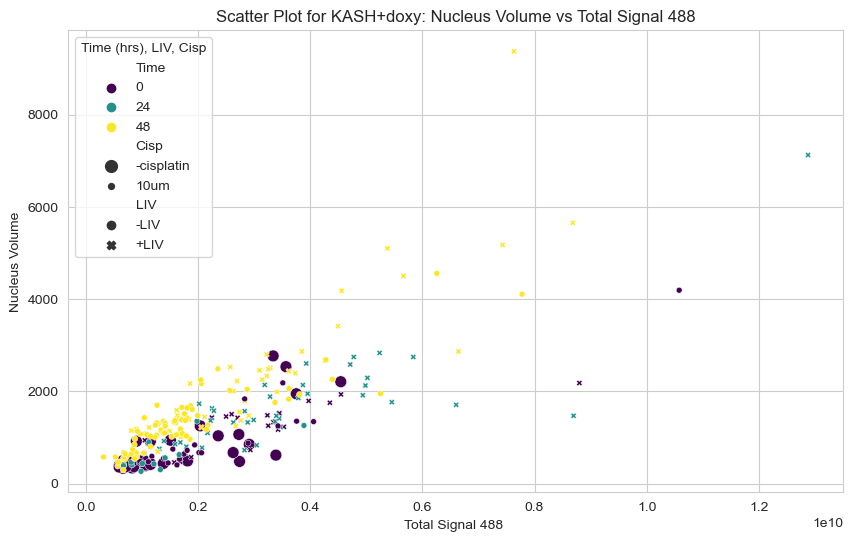

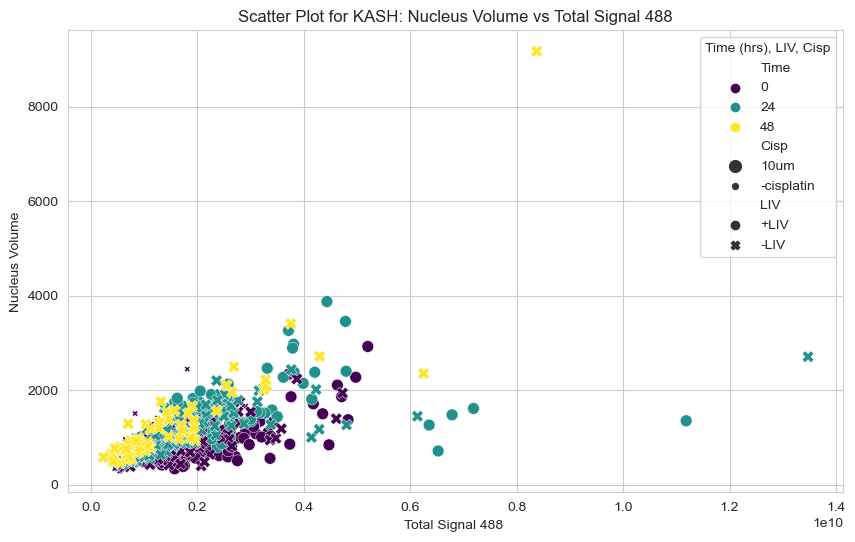

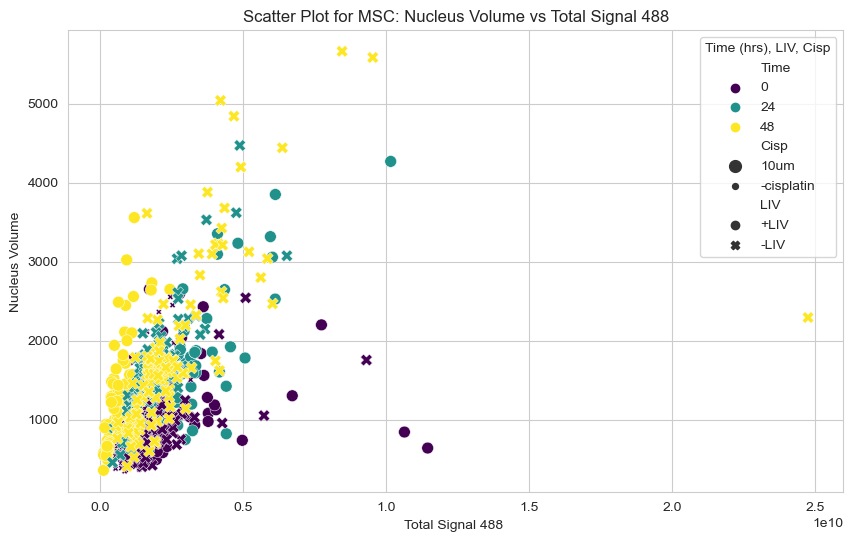

In [48]:
# Create a scatter plot for each cell type
for cell_type in cell_types:
    # Filter the DataFrame for the current cell type
    df_cell = final_df[final_df['Cell Type'] == cell_type]

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_cell, x='Total_signal_488', y= 'Nucleus_volume',
                    hue='Time', style='LIV', size='Cisp', palette='viridis')

    # Adding plot title and labels
    plt.title(f'Scatter Plot for {cell_type}: Nucleus Volume vs Total Signal 488')
    plt.xlabel('Total Signal 488 ')
    plt.ylabel('Nucleus Volume')

    # Show the plot
    plt.legend(title='Time (hrs), LIV, Cisp')
    plt.show()

In [49]:
def calculate_correlations(df):
    correlation_avg_signal = df[['Nucleus_volume', 'Average_signal_488']].corr().iloc[0, 1]
    correlation_total_signal = df[['Nucleus_volume', 'Total_signal_488']].corr().iloc[0, 1]
    return pd.Series({'Correlation_Avg_Signal': correlation_avg_signal, 'Correlation_Total_Signal': correlation_total_signal})

# Group by 'Group' and apply the correlation function
correlation_table = final_df.groupby('Group').apply(calculate_correlations)

correlation_table


,Correlation_Avg_Signal,Correlation_Total_Signal
Group,,
KASH+doxy_+LIV_10um_0hr,-0.339234,0.772799
KASH+doxy_+LIV_10um_24hr,-0.203975,0.817729
KASH+doxy_+LIV_10um_48hr,-0.244634,0.875256
KASH+doxy_-LIV_-cisplatin_0hr,-0.271501,0.779720
KASH+doxy_-LIV_10um_0hr,-0.248440,0.950048
KASH+doxy_-LIV_10um_24hr,-0.278298,0.759422
KASH+doxy_-LIV_10um_48hr,0.145120,0.890239
KASH_+LIV_10um_0hr,-0.350938,0.733734
KASH_+LIV_10um_24hr,-0.240170,0.333886


C:\Users\nnina\AppData\Local\Temp\ipykernel_31240\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


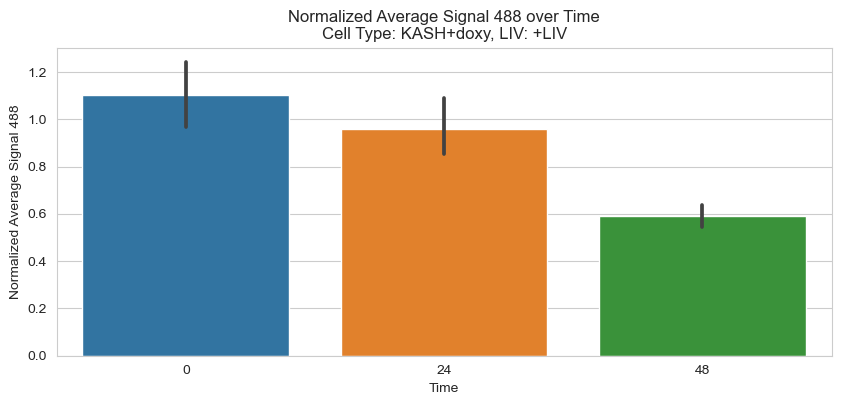

C:\Users\nnina\AppData\Local\Temp\ipykernel_31240\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


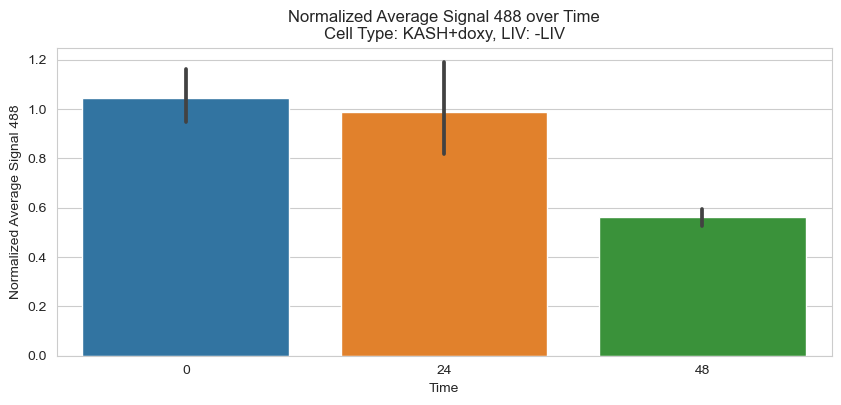

C:\Users\nnina\AppData\Local\Temp\ipykernel_31240\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


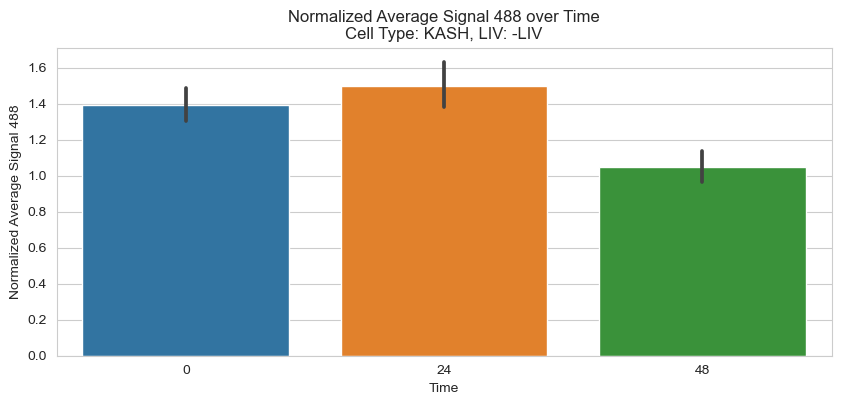

C:\Users\nnina\AppData\Local\Temp\ipykernel_31240\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


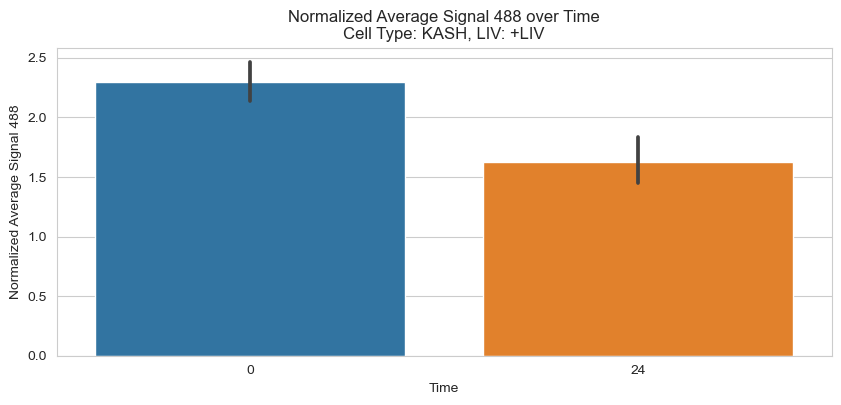

C:\Users\nnina\AppData\Local\Temp\ipykernel_31240\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


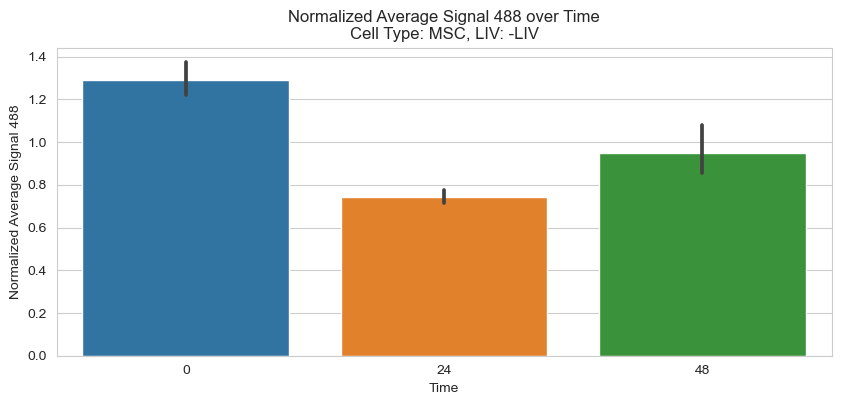

C:\Users\nnina\AppData\Local\Temp\ipykernel_31240\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


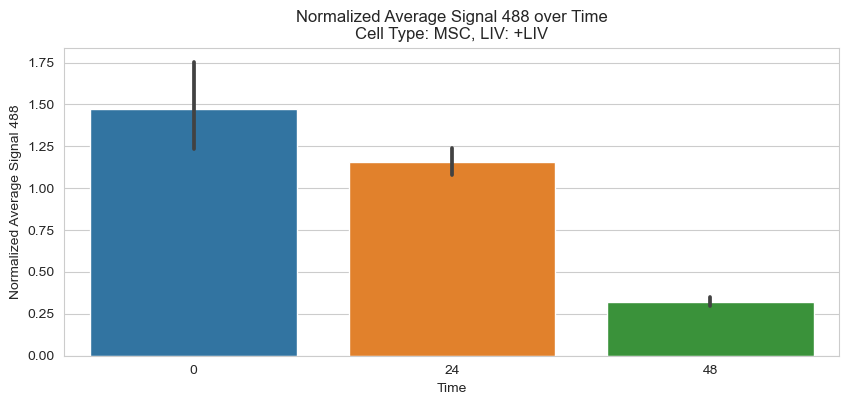

In [50]:
# Define the conditions for the bar charts
conditions = [
    {'Cell Type': 'KASH+doxy', 'LIV': '+LIV'},
    {'Cell Type': 'KASH+doxy', 'LIV': '-LIV'},
    {'Cell Type': 'KASH', 'LIV': '-LIV'},
    {'Cell Type': 'KASH', 'LIV': '+LIV'},
    {'Cell Type': 'MSC', 'LIV': '-LIV'},
    {'Cell Type': 'MSC', 'LIV': '+LIV'}
]

# Create bar charts
for condition in conditions:
    # Calculate the normalization factor based on condition
    normalization_factor = final_df[(final_df['Cell Type'] == condition['Cell Type']) &
                                    (final_df['Cisp'] == '-cisplatin') &
                                    (final_df['Time'] == 0) &
                                    (final_df['LIV'] == '-LIV')]['Average_signal_488'].mean()

    # Filter the DataFrame
    df_filtered = final_df[(final_df['Cell Type'] == condition['Cell Type']) &
                           (final_df['LIV'] == condition['LIV'])]

    # Normalize 'Average_signal_488'
    df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor

    # Plot
    plt.figure(figsize=(10, 4))
    sns.barplot(x='Time', y='Normalized_Avg_Signal_488', data=df_filtered)
    plt.title(f"Normalized Average Signal 488 over Time\nCell Type: {condition['Cell Type']}, LIV: {condition['LIV']}")
    plt.xlabel('Time')
    plt.ylabel('Normalized Average Signal 488')
    plt.show()


### Analysis of KASH+DOXY cells

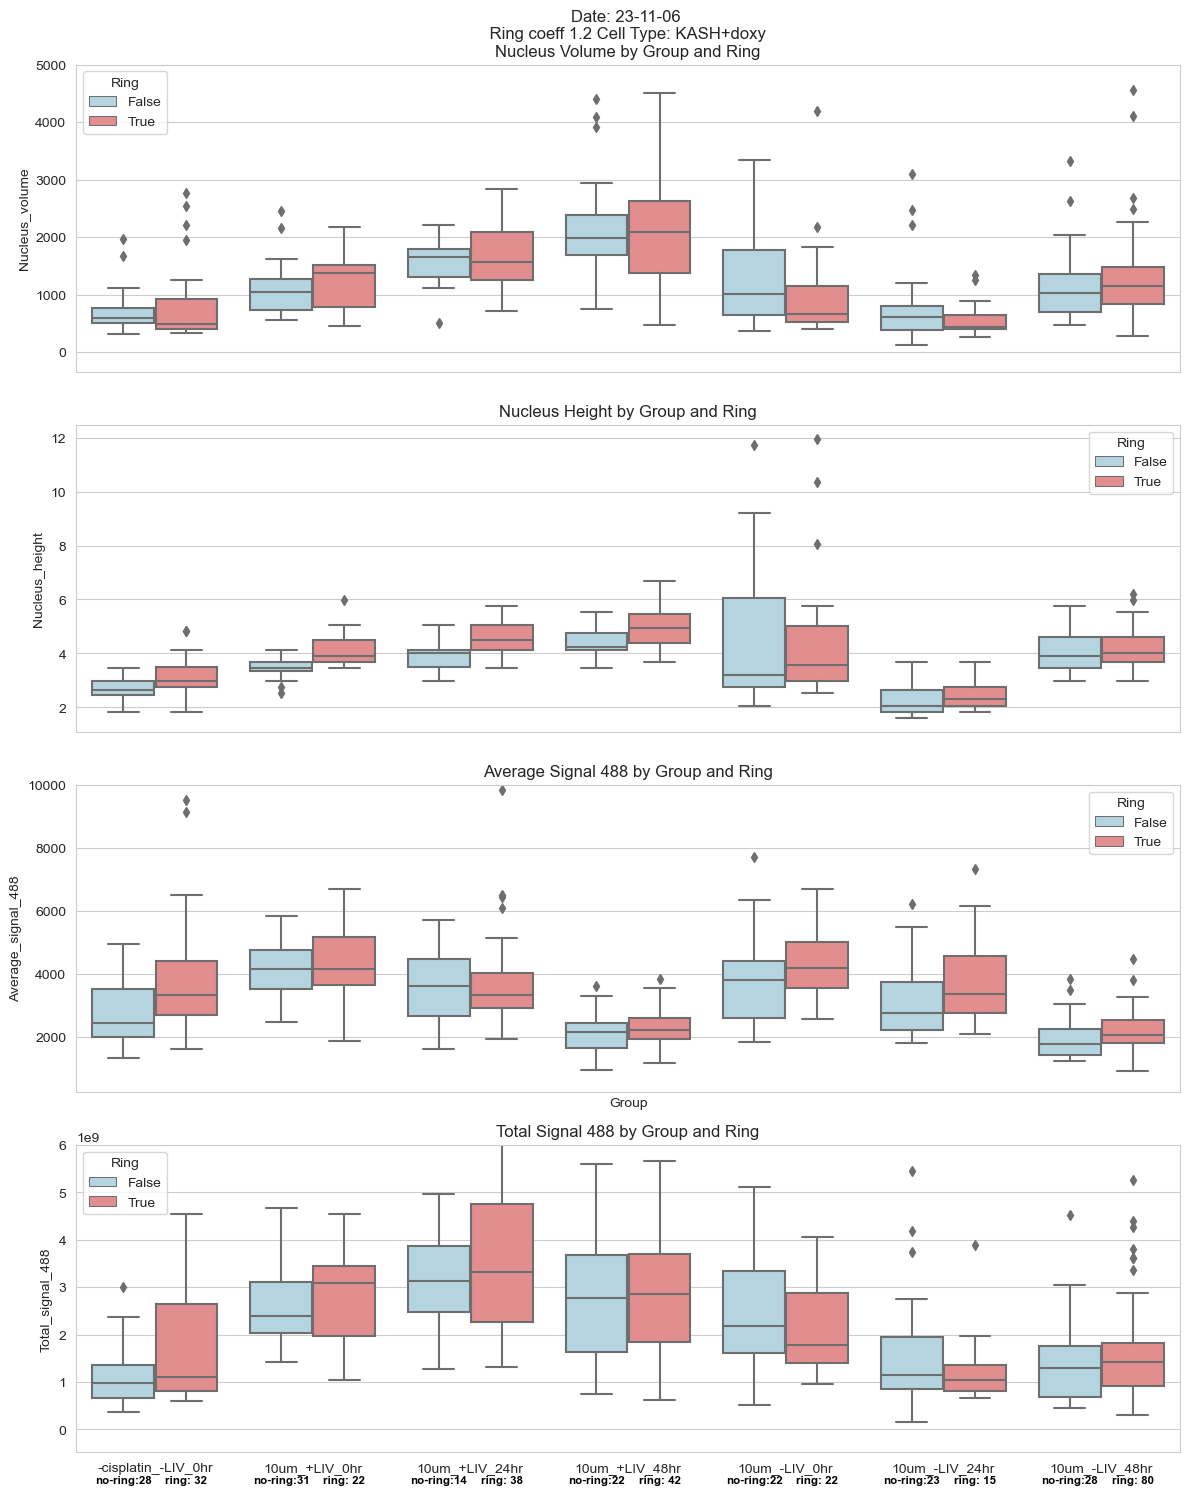

In [51]:
type_to_analyse = 'KASH+doxy'
fig = plot_metrics_by_group_and_ring(type_to_analyse, raw_df, RING_COEFF_CUT_OFF,  color1="lightblue", color2="lightcoral",
                                     y_max_nucleus_volume=5000, y_max_avg_signal_488=10000, y_max_total_signal_488=0.6e10)
plt.show()

### Analysis of KASH cells

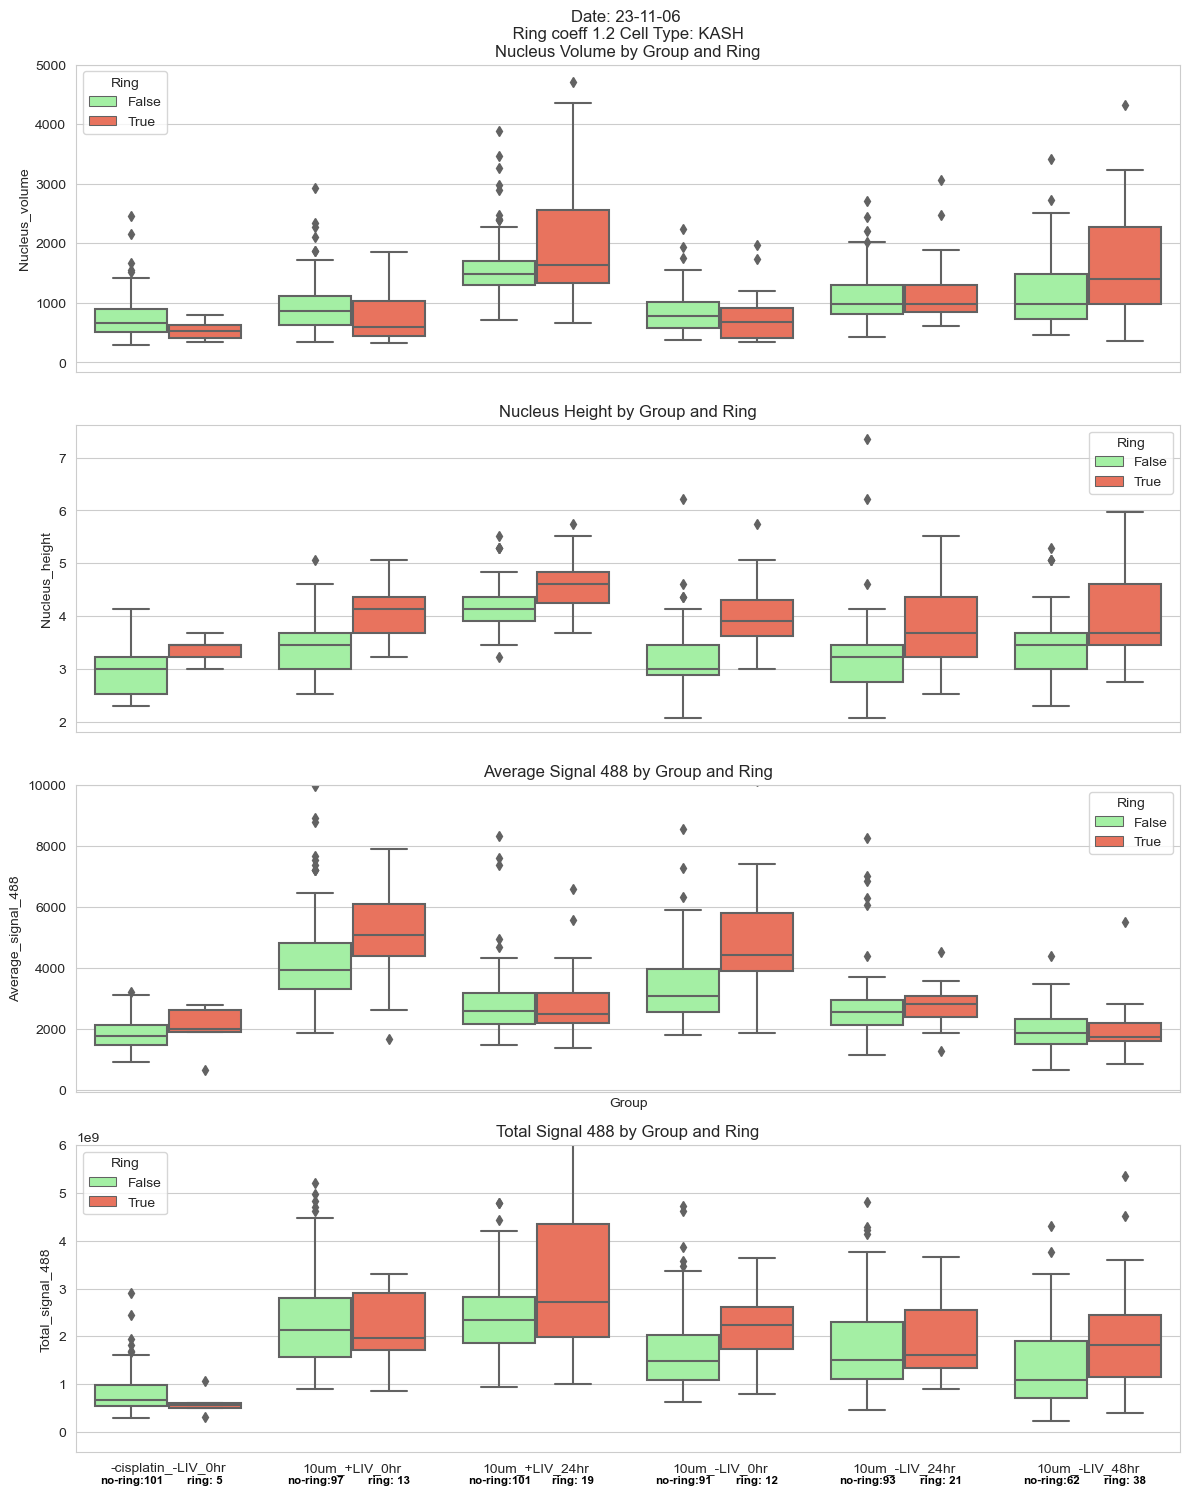

In [52]:
type_to_analyse = 'KASH'
fig = plot_metrics_by_group_and_ring(type_to_analyse, raw_df, RING_COEFF_CUT_OFF,  color1="palegreen", color2="tomato",
                                     y_max_nucleus_volume=5000, y_max_avg_signal_488=10000, y_max_total_signal_488=0.6e10)
plt.show()

### Analysis of MSC cells

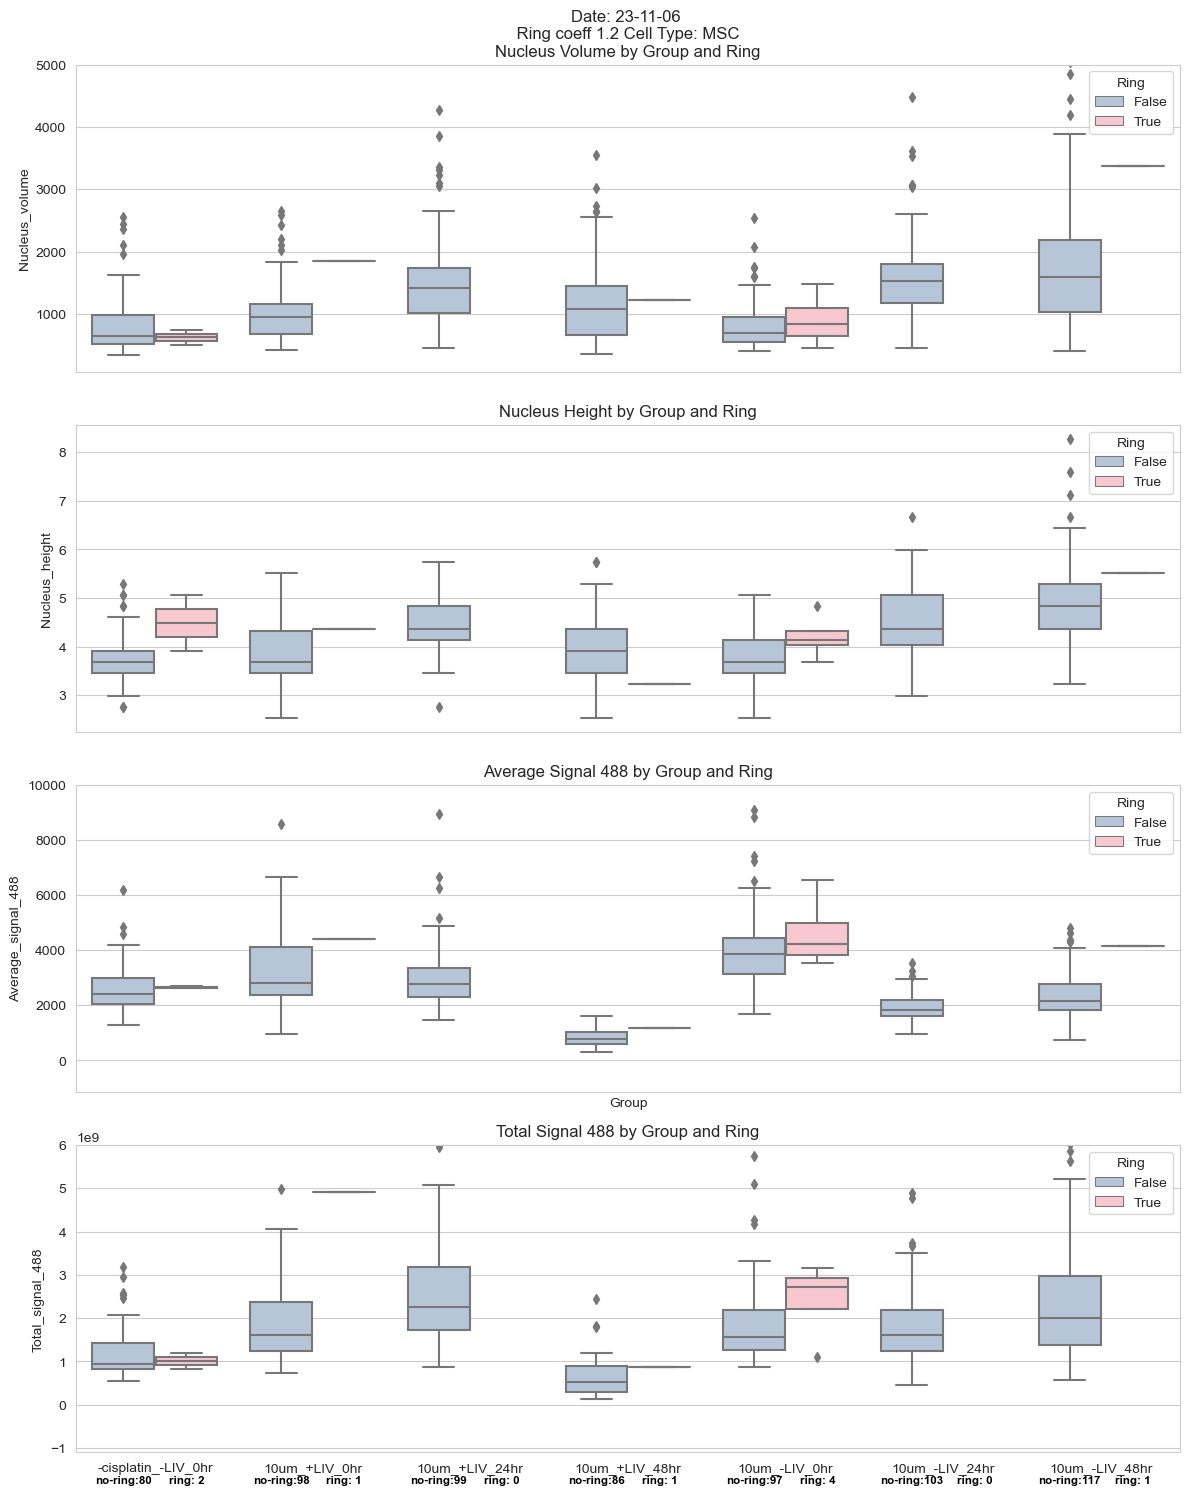

In [53]:
type_to_analyse = 'MSC'
fig = plot_metrics_by_group_and_ring(type_to_analyse, raw_df, RING_COEFF_CUT_OFF,  color1="lightsteelblue", color2="pink",
                                     y_max_nucleus_volume=5000, y_max_avg_signal_488=10000, y_max_total_signal_488=0.6e10)
plt.show()

In [54]:
### Investigate ring or no ring criterias

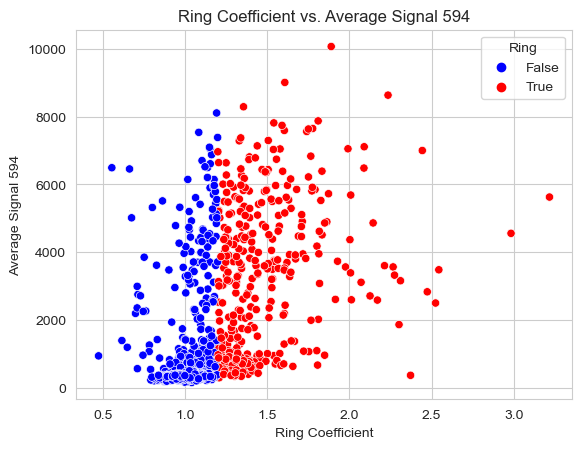

In [55]:
sns.scatterplot(data=raw_df, x='Ring_coefficient', y='Average_signal_594', hue='Ring', palette=['blue', 'red'])

# Adding titles and labels for clarity
plt.title('Ring Coefficient vs. Average Signal 594')
plt.xlabel('Ring Coefficient')
plt.ylabel('Average Signal 594')

# Display the plot
plt.show()



In [56]:
# between 'Ring_coefficient' and 'Average_signal_594' for each group
grouped_correlation = raw_df.groupby('Group')[['Ring_coefficient', 'Average_signal_594']].corr().iloc[0::2, -1].reset_index()

# Adjusting the columns for clarity
grouped_correlation.columns = ['Group', 'Variable', 'Correlation with Average_signal_594']
grouped_correlation = grouped_correlation.drop(columns=['Variable']).reset_index(drop=True)
grouped_correlation

,Group,Correlation with Average_signal_594
0,KASH+doxy_+LIV_10um_0hr,0.548559
1,KASH+doxy_+LIV_10um_24hr,0.342313
2,KASH+doxy_+LIV_10um_48hr,0.518938
3,KASH+doxy_-LIV_-cisplatin_0hr,0.310313
4,KASH+doxy_-LIV_10um_0hr,0.334440
5,KASH+doxy_-LIV_10um_24hr,-0.136371
6,KASH+doxy_-LIV_10um_48hr,0.278658
7,KASH_+LIV_10um_0hr,0.316193
8,KASH_+LIV_10um_24hr,0.671136
9,KASH_-LIV_-cisplatin_0hr,0.232763


C:\Users\nnina\miniconda3\envs\mal_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\nnina\AppData\Local\Temp\ipykernel_31240\1754923607.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Cluster')


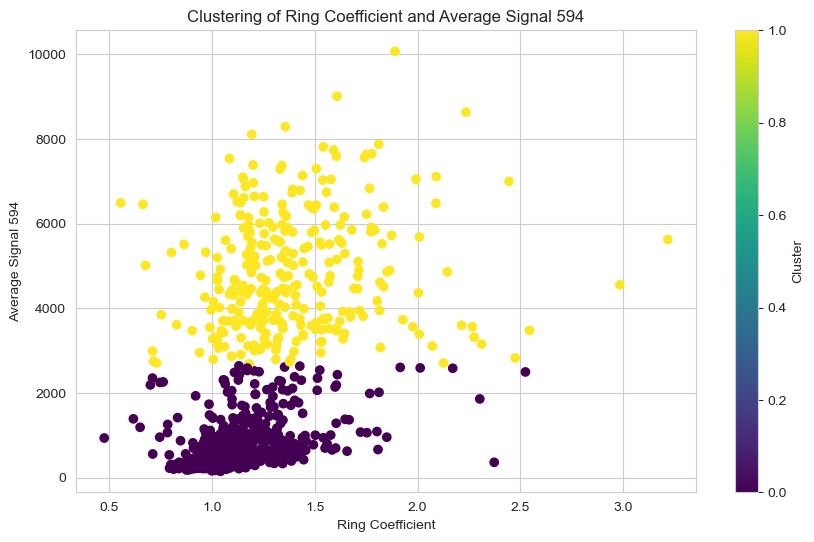

In [57]:
# Preparing data for clustering
X = raw_df[['Ring_coefficient', 'Average_signal_594']]

# Applying K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Assigning cluster labels to the original data
raw_df['Cluster'] = kmeans.labels_

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(raw_df['Ring_coefficient'], raw_df['Average_signal_594'], c=raw_df['Cluster'], cmap='viridis', marker='o')
plt.title('Clustering of Ring Coefficient and Average Signal 594')
plt.xlabel('Ring Coefficient')
plt.ylabel('Average Signal 594')
plt.colorbar(label='Cluster')
plt.show()


## Subproject Overview
The objective of this project is to assess the presence or absence of a ring in the red channel of cells, utilizing a dataset comprising 41 3D czi images. This dataset encapsulates a total of 266 cells. The evaluation process will involve a detailed analysis conducted by two reviewers, Sean and Shayla, under the guidance of Anamaria. The analysis aims to categorize each cell based on the presence or absence of a ring on the red channel.

### Data Preparation and Methodology
#### Data Provision:
A comprehensive list detailing all 266 cells, inclusive of image names and cell numbers, will be provided. Additionally, png images with labeled cell numbers and the original czi images will be supplied for thorough investigation.
#### Training and Testing Sets:
The dataset will be randomly divided into two subsets: 80% for training (approximately 213 cells) and 20% for testing (approximately 53 cells).
### Analytical Methods
#### Threshold Analysis for 'Ring Coefficient':

This involves determining an optimal threshold for the "Ring Coefficient" using the training set. The decision might be supported by analyzing two histograms.

#### Clustering Approach:

A clustering method will be applied based on "Red Channel Intensity" and "Ring Coefficient". Analysis of a scatter plot, colored by the hue of human labeling, will help identify challenging cases and disagreements between reviewers.

#### Random Forest Model:

A random forest model will be developed, utilizing all available features. The impact of including the volume feature on the model's accuracy will also be explored.

### Accuracy Assessment
The accuracy of all three predictive methods will be calculated. Additionally, an innovative approach to assess human accuracy will be implemented, considering Sean's expertise as the benchmark (gold standard) and Shayla's input as representative of a novice researcher's perspective.
Professional Evaluation

### Strengths:
#### Comprehensive Data Analysis:
The project adopts a multi-faceted approach, employing statistical, clustering, and machine learning methods, which enhances the robustness of the findings.
#### Human Element:
Including human reviewers adds a valuable layer of qualitative analysis, enriching the dataset with expert and novice perspectives.

### Areas for Improvement:
#### Reviewer Bias Mitigation:
To further strengthen the study, incorporating more reviewers could help mitigate individual bias and provide a broader consensus on cell classification.
#### Automated Pre-Processing:
Implementing automated pre-processing steps to standardize images before analysis could reduce variability and improve model performance.
#### Cross-Validation:
Employing cross-validation techniques within the training set could offer a more reliable estimation of model performance and generalizability.

### Conclusion
The project's structured approach, combining human insight with advanced analytical techniques, sets a solid foundation for accurately classifying cells based on the presence or absence of a ring on the red channel. By addressing the suggested improvements, the project could further enhance its methodological rigor and the reliability of its findings.